# Using DeepGaze IIE to Generate Saliency Predictions on the shared1000 NSD Stimuli (COCO Images) 

The NSD experiment uses the COCO dataset as stimuli shown to the participants while they were recorded with fMRI. 

The participants performed a long-term continuous recognition task while viewing the images.

In total, `73,000` unique images were prepared, where each participant viewed `10,000` distinct images over ~`40` scanning sessions. Additionally, a special set of `1000` images as part of shared image was seen by all participants. 
In this project we are only interested in the shared1000 subset of the total 73,000 NSD image stimuli. 

Written by Lisa Heinemann  
Last edited: 19/05/2025

# Imports

In [27]:
from pathlib import Path
import pandas as pd
import numpy as np
#from scipy.misc import face
# scipy.datasets is used because scipy.misc is deprecated
from scipy.datasets import face 
from scipy.ndimage import zoom
from scipy.special import logsumexp
from scipy import stats
# Added for the modelling 
from scipy.io import loadmat
# Do not think I need torch at the moment, just for modeling saliency maps with
# DeepGaze I, II, IIE, III later on

#import torch
import matplotlib.pyplot as plt
import os
import csv
import h5py
from typing import Union

import nibabel as nib
from IPython.display import Image, display

# To mask the betas for the relevanr ROIs
import nilearn
#from nilearn import image
#from nilearn import plotting
#from nilearn.image import math_img
#from nilearn.masking import apply_mask
#from nilearn.maskers import NiftiMasker

# to load the masks 
#from nilearn.input_data import NiftiMasker
import h5py
from typing import Union, List, Tuple
import pickle
import builtins
import os 
import sys
import struct
import time
import seaborn as sns
#import binsreg 
import random
#from binsreg import binsreg
# for saliency modeling to display progress bars of the loop iteration 
from tqdm import tqdm
# to open the nsd images 
#from PIL import Image

# For multiprocessing of get_betas()

from multiprocessing import Pool, cpu_count
# from nibabel.funcs import 

import imageio.v3 as iio
import imageio.v2 as iio
import matplotlib.pyplot as plt
import glob
import cv2
# Added pytorch implementation for the modeling of DeeGaze Saliency maps
import torch
print(torch.__version__)



1.12.1


## Path Indications 

In [28]:
# Set Base Directory I for the Ground truth eye tracking data 
############################################################################################
# Create a Path object for the base directory
# TODO: Change to the correct Path. Decide wether to use the private or public path.
#base_dir = Path('~/saliency-nsd-priv').expanduser()

# # Create a Path object for the base directory pub
# TODO: Change to the correct Path.
base_dir = Path('/gpfs01/bartels/group/lheinemann/saliency-nsd-pub').expanduser()

# Check if the base directory exists with an assert 
assert base_dir.exists(), f'{base_dir} does not exist'
# Print the base directory
print(base_dir)

# Combine paths to create new Path objects for the data directory and the save directory

# Path to the concatenated DataFrame 'df_expanded_data_subjs_concatenated_all.csv' containing all experimental data
# One line represents one fixation of one subject in the DataFrame 
data_dir = base_dir/ 'data/preprocessed/df_expanded_data_subjs_concatenated_all.csv'

# To load the actual jpg images responding to their name stored in img_id in the dataframe 
img_dir = base_dir /'stimuli/shared1000'

# The fixation maps are stored in the save_dir
save_dir = base_dir / 'data/fixation_and_saliency_maps'

# Path to where the saliency maps (based on first fixations only) are stored
salmaps_1st_path = base_dir / 'data/fixation_and_saliency_maps/saliency_map_all_and_first_fixations.h5'

# Add hdf5 file path to store the values of the saliency maps
hdf5_file_path_all_and_first_fixations = save_dir / 'saliency_map_all_and_first_fixations.h5'

# Check if the data and save directories exist with assert statements, if not assertion error is raised
assert data_dir.exists(), f'{data_dir} does not exist'
assert save_dir.exists(), f'{save_dir} does not exist'
assert img_dir.exists(), f'{img_dir} does not exist'

# Debug check: Print statement of path 
print(data_dir)
print(save_dir)
print(img_dir)
print(hdf5_file_path_all_and_first_fixations)

# Print the working directory to double check: should be /gpfs01/bartels/user/lheinemann/saliency-nsd/code/code_analysis_saliency-nsd/1_data-preprocessing/creation_of_dataframes
print (os.getcwd())

# TODO: See, wether I need this in my code. 
#stim_sz_px = 425
#stim_sz_deg = 8.4

/gpfs01/bartels/group/lheinemann/saliency-nsd-pub
/gpfs01/bartels/group/lheinemann/saliency-nsd-pub/data/preprocessed/df_expanded_data_subjs_concatenated_all.csv
/gpfs01/bartels/group/lheinemann/saliency-nsd-pub/data/fixation_and_saliency_maps
/gpfs01/bartels/group/lheinemann/saliency-nsd-pub/stimuli/shared1000
/gpfs01/bartels/group/lheinemann/saliency-nsd-pub/data/fixation_and_saliency_maps/saliency_map_all_and_first_fixations.h5
/gpfs01/bartels/user/lheinemann/nsd-static-saliency/scripts


Second path directions for the files that need to be loaded from the NSD dataset directory. 

In [ ]:
# Set roots relative to the base_dir to gain access to the NSD dataset

base_dir_nsd = Path('/gpfs01/bartels/group/nsd_dataset')
############################################################################################################

NSD_DATA_ROOT  = base_dir_nsd / 'nsddata'
STIM_ROOT  = NSD_DATA_ROOT / 'stimuli/nsd/'


stim_file = STIM_ROOT / 'nsd_stimuli.hdf5'
shared1000_file = STIM_ROOT / 'shared1000.tsv'
shared1000_dir = STIM_ROOT / 'shared1000'
exp_design_file = NSD_DATA_ROOT / 'experiments/nsd/nsd_expdesign.mat'
nsd_stiminfo_file = NSD_DATA_ROOT / 'experiments/nsd/nsd_stim_info_merged.csv'

print(nsd_stiminfo_file)
DATA_PATH = Path('/gpfs01/bartels/user/lheinemann/nsd-static-saliency/data')
print(DATA_PATH)

# ROI path 
ROI_PATH = NSD_DATA_ROOT/ 'ppdata/'

DEVICE = 'cpu'

# Path indication for df_nsd_trial (dataframe containing the nsd id, sub_num and the trial id as well as cocoId)
# This dataframe was created in the prior notebook
df_nsd_trial_file = save_dir / 'df_nsd_trial.csv'
print(df_nsd_trial_file)

/gpfs01/bartels/group/nsd_dataset/nsddata/experiments/nsd/nsd_stim_info_merged.csv
/gpfs01/bartels/user/lheinemann/nsd-static-saliency/data
/gpfs01/bartels/group/lheinemann/saliency-nsd-pub/data/fixation_and_saliency_maps/df_nsd_trial.csv


In [ ]:
# Print first lines of df_nsd_trial_file
df_nsd_trial = pd.read_csv(df_nsd_trial_file)
print(df_nsd_trial.head())

   nsdId  cocoId  subject1_rep0  subject1_rep1  subject1_rep2  subject2_rep0  \
0   2951  262145           2616           9716          27566           2616   
1   2991  262239          18458          18697          27711          18458   
2   3050  262414           6299           6448           6697           6299   
3   3078  524646           4289           4515           4537           4289   
4   3147  262690           8087           8443          26807           8087   

   subject2_rep1  subject2_rep2  subject3_rep0  subject3_rep1  ...  \
0           9716          27566           2616           9716  ...   
1          18697          27711          18458          18697  ...   
2           6448           6697           6299           6448  ...   
3           4515           4537           4289           4515  ...   
4           8443          26807           8087           8443  ...   

   subject5_rep2  subject6_rep0  subject6_rep1  subject6_rep2  subject7_rep0  \
0          27566  

### Load the TSV File of Shared1000 - NSD Images 

In [30]:
#Load the tsv file shared1000.tsv file containing the different nsdids of the images that were shown to all participants (*N*=8) to a list and name the first row nsd_id

# Initialize an empty list to store the data
shared1000_list = []

# Open and read the TSV file
with open(shared1000_file, 'r') as file:
    reader = csv.reader(file, delimiter='\t')
    for row in reader:
        shared1000_list.append(int(row[0]))  # Remove the storing of the values with brackets and apostrophes to store the values as integers

# Rename the first column to 'nsd_id'
#shared1000_list[0][0] = 'nsd_id'

# Print the first few rows to verify
print(shared1000_list[:5])


# Remember Python starts with zero-based indexing

##################################
# Load the relevant files to access and print the according nsd img ids 
# ToDO readapt this function 
#########################################

# Load the share1000_file (tsv-file) containing a list of the nsd ids belonging 
# to the shared1000 dataset
shared1000_file

   

[2951, 2991, 3050, 3078, 3147]


PosixPath('/gpfs01/bartels/group/nsd_dataset/nsddata/stimuli/nsd/shared1000.tsv')

In [31]:
shared1000_list

[2951,
 2991,
 3050,
 3078,
 3147,
 3158,
 3165,
 3172,
 3182,
 3387,
 3435,
 3450,
 3490,
 3627,
 3683,
 3688,
 3730,
 3810,
 3843,
 3848,
 3857,
 3914,
 3952,
 4052,
 4059,
 4130,
 4157,
 4250,
 4326,
 4424,
 4437,
 4613,
 4668,
 4691,
 4769,
 4787,
 4836,
 4870,
 4893,
 4931,
 5035,
 5107,
 5205,
 5286,
 5302,
 5339,
 5428,
 5460,
 5503,
 5543,
 5575,
 5584,
 5603,
 5715,
 5879,
 5891,
 6133,
 6200,
 6223,
 6432,
 6445,
 6490,
 6515,
 6522,
 6525,
 6559,
 6641,
 6714,
 6802,
 7008,
 7040,
 7121,
 7208,
 7337,
 7367,
 7410,
 7419,
 7481,
 7655,
 7660,
 7841,
 7860,
 7945,
 7949,
 7955,
 8007,
 8110,
 8205,
 8226,
 8263,
 8275,
 8319,
 8388,
 8395,
 8416,
 8436,
 8466,
 8510,
 8632,
 8647,
 8808,
 8844,
 8926,
 8934,
 9028,
 9049,
 9148,
 9231,
 9435,
 9463,
 9681,
 9723,
 9805,
 9848,
 9866,
 9918,
 9979,
 10007,
 10047,
 10065,
 10106,
 10108,
 10245,
 10394,
 10472,
 10508,
 10587,
 10601,
 10611,
 10908,
 11160,
 11334,
 11488,
 11522,
 11567,
 11618,
 11636,
 11690,
 11726,
 1179

## Installation/ Intialization of DeepGaze IIE

To install DeepGaze on project directory:

Inside the `src/DeepGaze/` directory use `pip install -e .`. 

In [32]:
# Install deepgaze-pytorch package
%pip install deepgaze-pytorch
import sys
sys.path.append('/nsd-static-saliency/deepgaze')

import deepgaze_pytorch as deepgaze_pytorch

# the problem here could be that the versions are not the same 
# see for more ....
print("deepgaze_pytorch successfully imported from: ", deepgaze_pytorch.__file__)

# Verify available models 
# List available attributes and methods
print(dir(deepgaze_pytorch))

# Check if DeepGazeIIE is available
if hasattr(deepgaze_pytorch, 'DeepGazeIIE'):
    print("DeepGazeIIE is available")
else:
    print("DeepGazeIIE is not available")

# Check if DeepGazeII is available
if hasattr(deepgaze_pytorch, 'DeepGazeII'):
    print("DeepGazeII is available")
else:
    print("DeepGazeII is not available")
    

Note: you may need to restart the kernel to use updated packages.


/gpfs01/bartels/user/lheinemann/miniconda3/envs/nsd-static-saliency/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libc10_cuda.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


deepgaze_pytorch successfully imported from:  /gpfs01/bartels/user/lheinemann/miniconda3/envs/nsd-static-saliency/lib/python3.8/site-packages/deepgaze_pytorch/__init__.py
['DeepGazeI', 'DeepGazeIIE', 'DeepGazeIII', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'deepgaze1', 'deepgaze2e', 'deepgaze3', 'features', 'layers', 'modules']
DeepGazeIIE is available
DeepGazeII is not available


## 1. Intialize DeepGaze IIE for running 

In [ ]:
### Set the model used -- In this case: DeepGaze IIE ###

# DEVICE = 'cuda'
DEVICE = 'cpu'

model = deepgaze_pytorch.DeepGazeIIE(pretrained=True).to(DEVICE)

######################################
image = face()

# Load precomputed centerbias log density (from MIT1003) over a 1024x1024 image
# Possibility to download the centerbias from https://github.com/matthias-k/DeepGaze/releases/download/v1.0.0/centerbias_mit1003.npy
# Alternatively use of a uniform centerbias via `centerbias_template = np.zeros((1024, 1024))`.
centerbias_template = np.load('../deepgaze/centerbias_mit1003.npy')
# Rescale to match image size
centerbias = zoom(centerbias_template, (image.shape[0]/centerbias_template.shape[0], image.shape[1]/centerbias_template.shape[1]), order=0, mode='nearest')
# Renormalize log density
centerbias -= logsumexp(centerbias)

image_tensor = torch.tensor([image.transpose(2, 0, 1)]).to(DEVICE)
centerbias_tensor = torch.tensor([centerbias]).to(DEVICE)

log_density_prediction = model(image_tensor, centerbias_tensor)

/gpfs01/bartels/user/lheinemann/miniconda3/envs/nsd-static-saliency/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/gpfs01/bartels/user/lheinemann/miniconda3/envs/nsd-static-saliency/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Loaded pretrained weights for efficientnet-b5


Using cache found in /gpfs01/bartels/user/lheinemann/.cache/torch/hub/pytorch_vision_v0.6.0
/gpfs01/bartels/user/lheinemann/miniconda3/envs/nsd-static-saliency/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Using cache found in /gpfs01/bartels/user/lheinemann/.cache/torch/hub/pytorch_vision_v0.6.0
/gpfs01/bartels/user/lheinemann/miniconda3/envs/nsd-static-saliency/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You 

In [34]:
centerbias_template

array([[-17.50040368, -17.50131567, -17.50313877, ..., -23.87590433,
        -23.90519951, -23.92010692],
       [-17.50154704, -17.50245819, -17.5042796 , ..., -23.86814441,
        -23.89734273, -23.91219991],
       [-17.50384048, -17.50474996, -17.506568  , ..., -23.85494215,
        -23.88397185, -23.89874158],
       ...,
       [-19.97306418, -19.96811622, -19.95829542, ..., -19.17078152,
        -19.18453352, -19.19162509],
       [-19.98281852, -19.97785025, -19.96798926, ..., -19.17161535,
        -19.18537989, -19.19247827],
       [-19.98771849, -19.98273981, -19.97285824, ..., -19.17183865,
        -19.18560709, -19.19270764]])

In [ ]:
"""
f, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))
axs[0].imshow(image)
axs[0].set_axis_off()

axs[1].matshow(log_density_prediction.detach().cpu().numpy()[0, 0])  # first image in batch, first (and only) channel
axs[1].set_axis_off() """

' # CHECK, WHETHER THIS CODE BLOCK IS NECCESSARY\nf, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))\naxs[0].imshow(image)\naxs[0].set_axis_off()\n\naxs[1].matshow(log_density_prediction.detach().cpu().numpy()[0, 0])  # first image in batch, first (and only) channel\naxs[1].set_axis_off() '

In [36]:
#log_density_prediction

In [37]:
""" print(image_tensor.shape)
print(image.shape)
print(log_density_prediction.shape) """

' print(image_tensor.shape)\nprint(image.shape)\nprint(log_density_prediction.shape) '

In [ ]:
""" image_data_set = h5py.File(stim_file, 'r')

for key, value in image_data_set.items() :
    print(key,": \n", value,"\n")
    
image_data = np.copy(image_data_set['imgBrick'])
image_data_set.close() """

' image_data_set = h5py.File(stim_file, \'r\')\n\nfor key, value in image_data_set.items() :\n    print(key,": \n", value,"\n")\n    \nimage_data = np.copy(image_data_set[\'imgBrick\'])\n# TODO: Think about access thes to only the shared000 images \nimage_data_set.close() '

In [39]:
""" # Load the image data from the HDF5 file
print(f"Loading image data from: {stim_file}")
with h5py.File(stim_file, 'r') as image_data_set:
    # Print the shape of the loaded image data
    print(f"Loaded image data shape: {image_data.shape}")

# Print information about the loaded image data
print("Image data shape:", image_data.shape)  # Original: 10,000 x 3 x 227 x 227
print("Image data type:", image_data.dtype)
print("Min and max pixel values of the first image:", np.min(image_data[0]), np.max(image_data[0])) """

' # Load the image data from the HDF5 file\nprint(f"Loading image data from: {stim_file}")\nwith h5py.File(stim_file, \'r\') as image_data_set:\n    # Print the shape of the loaded image data\n    print(f"Loaded image data shape: {image_data.shape}")\n\n# Print information about the loaded image data\nprint("Image data shape:", image_data.shape)  # Original: 10,000 x 3 x 227 x 227\nprint("Image data type:", image_data.dtype)\nprint("Min and max pixel values of the first image:", np.min(image_data[0]), np.max(image_data[0])) '

## 2. Preparation for correlation_w_fMRI: Load the image stimuli of shared1000 and load and mask the betas of the NSD dataset (resolution 1.8mm) for the relevant ROIs

NSD ID: 2951


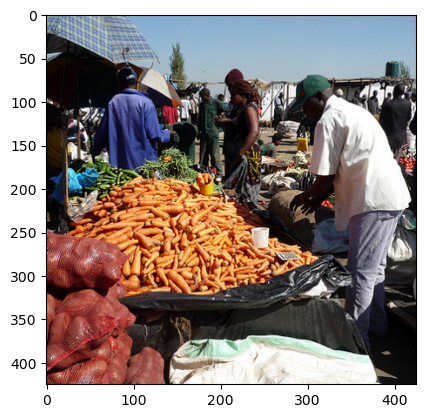

In [40]:
nsd_id = 2951
img_id_num = 1  
# 
print(f"NSD ID: {nsd_id}")
# Load the image, the images are stored in this format: shared0001_nsd02951.png for the fisrt image file of the shared1000
img_path = STIM_ROOT / "shared1000" /f"shared000{img_id_num}_nsd0{nsd_id}.png"
nsd_id_img = iio.imread(img_path)
plt.imshow(nsd_id_img)


### 2.1 Load the relevant NSD IDs

Load the dataframe that stores the trial and reptition numbers for the nsd participants 

In [41]:
# Load the in the first notebook '00_Creating_and_visualizing_roi_mask_01.ipynb' created dataframe
df_nsd_trial_file

# TODO: Adapt this logic to the loaded dataframe with the trial ids of the shared1000 of the nsd dataset 

sub_num=1

# Print the file path of the loaded dataframe
print(f"DataFrame file path: {df_nsd_trial_file}")


DataFrame file path: /gpfs01/bartels/group/lheinemann/saliency-nsd-pub/data/fixation_and_saliency_maps/df_nsd_trial.csv


## Load the NSD images correctly so that they can be processed by DeepGaze 

### Iterate through all img_ids and load the shared001_nsd02951.png files as npy. files for the generation of saliency maps with DeepGazeIIE

### Load the stimuli as a numpy array to use it for the saliency maps of DeepGaze IIE 

In [42]:
shared1000_dir = STIM_ROOT / 'shared1000'

In [43]:
def load_stimuli_as_numpy(shared1000_dir, shared1000_list, plot_images=False):
    stimuli_arrays = []  # List to store numpy arrays of stimuli

    # Iterate through all nsd_ids in the shared1000 list
    for i, nsd_id in enumerate(shared1000_list):
        print(f"Processing NSD ID: {nsd_id}")

        # Search for the files with the corresponding nsd_id in the directory
        nsd_candidate_files = list(shared1000_dir.glob(f'*_nsd{nsd_id:05d}.png'))
        if not nsd_candidate_files:
            print(f"No file found for NSD ID: {nsd_id}")
            continue

        # Get list of all files in the directory
        fnames = [f for f in shared1000_dir.iterdir() if f.is_file()]
        # Print the first 10 file names
        fnames[:10]

        # Load the first matching file (assuming one file per NSD ID)
        img_path = nsd_candidate_files[0]
        try:
            # Load the image and convert it to a numpy array
            nsd_id_img = iio.imread(str(img_path))  # Convert Path to string
            nsd_id_img = np.array(nsd_id_img)

            # Append the numpy array to the list
            stimuli_arrays.append(nsd_id_img)

            # Plot the image if plot_images is True
            # but only for the first 4 images
            if plot_images and i < 4:
                plt.figure(figsize=(3, 3))
                plt.imshow(nsd_id_img, cmap='gray', interpolation='None')
                plt.title(f"NSD ID: {nsd_id}")
                plt.axis('off')
                plt.show()

        except FileNotFoundError:
            print(f"Image not found for NSD ID: {nsd_id} at {img_path}")
        except Exception as e:
            print(f"Error loading image for NSD ID: {nsd_id}: {e}")

    return stimuli_arrays

### Function call - load_stimuli_as_numpy

Processing NSD ID: 2951


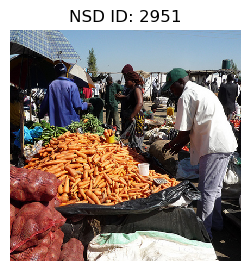

Processing NSD ID: 2991


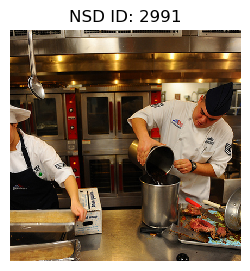

Processing NSD ID: 3050


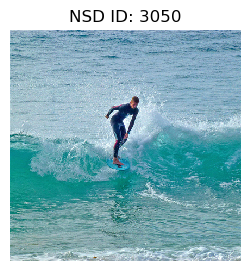

Processing NSD ID: 3078


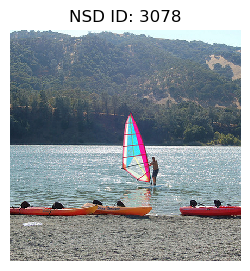

Processing NSD ID: 3147
Processing NSD ID: 3158
Processing NSD ID: 3165
Processing NSD ID: 3172
Processing NSD ID: 3182
Processing NSD ID: 3387
Processing NSD ID: 3435
Processing NSD ID: 3450
Processing NSD ID: 3490
Processing NSD ID: 3627
Processing NSD ID: 3683
Processing NSD ID: 3688
Processing NSD ID: 3730
Processing NSD ID: 3810
Processing NSD ID: 3843
Processing NSD ID: 3848
Processing NSD ID: 3857
Processing NSD ID: 3914
Processing NSD ID: 3952
Processing NSD ID: 4052
Processing NSD ID: 4059
Processing NSD ID: 4130
Processing NSD ID: 4157
Processing NSD ID: 4250
Processing NSD ID: 4326
Processing NSD ID: 4424
Processing NSD ID: 4437
Processing NSD ID: 4613
Processing NSD ID: 4668
Processing NSD ID: 4691
Processing NSD ID: 4769
Processing NSD ID: 4787
Processing NSD ID: 4836
Processing NSD ID: 4870
Processing NSD ID: 4893
Processing NSD ID: 4931
Processing NSD ID: 5035
Processing NSD ID: 5107
Processing NSD ID: 5205
Processing NSD ID: 5286
Processing NSD ID: 5302
Processing NSD I

In [44]:
# Call the function and get the numpy arrays for the shared1000 images
# Takes 14s to run 
stimuli_numpy_arrays = load_stimuli_as_numpy(shared1000_dir, shared1000_list, plot_images= True)

In [46]:
# RUN ONLY IF MODEL HAS NOT BEEN INSTANTIATED BEFORE 
# DEVICE = 'cuda'
# model = deepgaze_pytorch.DeepGazeIIE(pretrained=True).to(DEVICE)

## Function defintion "gen_saliency()" to generate the model based saliency maps 
Model is in this case: DeepGaze IIE

alternative approch all in one - quest is that complete? 

- Here Image is supposed to be [H x W x C] 
    But NSD images are [C x H x W] 

In [47]:
def gen_saliency(image, model, channel_loc=0):
    '''
    Generate saliency map for input image using DeepGaze 
    
    Args:
        image: input image 
        model: DeepGaze model instance
        channel_loc: index of the channel dimension of the image
    
    Returns:
        log_density_prediction: generated saliency map 
    '''  
    model = model 

    # Ensure the image is in the correct format (C x H x W)
    if image.shape[-1] == 3:  # If the channel is the last dimension
        image = image.transpose(2, 0, 1)  # Convert to (C, H, W)

    # Convert image to tensor
    image_tensor = torch.tensor([image]).to(DEVICE)

    # Process centerbias
    centerbias = zoom(centerbias_template, (image.shape[1] / centerbias_template.shape[0], 
                                            image.shape[2] / centerbias_template.shape[1]), 
                      order=0, mode='nearest')
    centerbias -= logsumexp(centerbias)
    centerbias_tensor = torch.tensor([centerbias]).to(DEVICE)

    # Generate saliency map
    log_density_prediction = model(image_tensor, centerbias_tensor)
    return log_density_prediction

In [48]:
def plot_saliency(image, log_density_prediction, channel_loc = 0):
    '''
    Plot saliency maps using the log density prediction generated by DeepGaze
    
    Args:
        image: input image
        log_density_prediction: saliency map generated with DeepGaze
        channel_loc: index of the channel dimesion of the image
    
    Returns:
        None
    '''
    f, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,6))
    if channel_loc == 0:
        #axs[0].imshow(image.transpose((0,1,2)), cmap='gray', interpolation='None')
        axs[0].imshow(image, cmap='gray', interpolation='None')
    elif channel_loc == 2:
         axs[0].imshow(image, cmap='gray', interpolation='None')
        
    axs[1].matshow(log_density_prediction.detach().cpu().numpy()[0, 0])
    axs[0].set_axis_off()
    axs[1].set_axis_off()

In [49]:
def gen_and_plot_saliency(model, image, channel_loc = 0, plot_images=False):
    '''
    Generate and plot saliency maps 
    
    Args:
        model: DeepGaze model instance
        image: input image
        channel_loc: index of the channel dimesion of the image
        
    Returns: 
        None:
    '''
    log_density_prediction = gen_saliency(image,model,channel_loc)
    # plot_saliency(image, log_density_prediction, channel_loc)

    print(f"Image shape: {image.shape}")
    print(f"Log density prediction shape: {log_density_prediction.shape}")

     # Limit the number of images to plot to 4
    #num_images_to_plot = max(len(images), 4)

    if plot_images :
        plot_saliency(image, log_density_prediction, channel_loc)
    

    return log_density_prediction
    

### Explanation of shape of image tensor

The image_tensor is created by transposing the image to [C, H, W] and adding a batch dimension, resulting in [1, 3, 768, 1024].
This is the expected input shape for PyTorch models, where:
1 is the batch size.
3 is the number of channels (RGB).
768 and 1024 are the height and width of the image.

In [50]:
print(image_tensor.shape)

torch.Size([1, 3, 768, 1024])


## Function call *generate_saliency_map()* just for one image of the 73k NSD image dataset 

In [51]:
# Just print the slaiency map of a basic image iwth deepgaze iie applied 
image = stimuli_numpy_arrays[0]

Image shape: (425, 425, 3)
Log density prediction shape: torch.Size([1, 1, 425, 425])


tensor([[[[-17.4881, -17.4881, -17.4881,  ..., -21.2944, -21.6038, -21.6038],
          [-17.4881, -17.4881, -17.4881,  ..., -21.2944, -21.6038, -21.6038],
          [-17.4881, -17.4881, -17.4881,  ..., -21.2944, -21.6038, -21.6038],
          ...,
          [-17.8691, -17.8691, -17.8691,  ..., -18.1440, -18.2970, -18.2970],
          [-17.9949, -17.9949, -17.9949,  ..., -18.1537, -18.3093, -18.3093],
          [-17.9949, -17.9949, -17.9949,  ..., -18.1537, -18.3093, -18.3093]]]],
       dtype=torch.float64, grad_fn=<LogsumexpBackward0>)

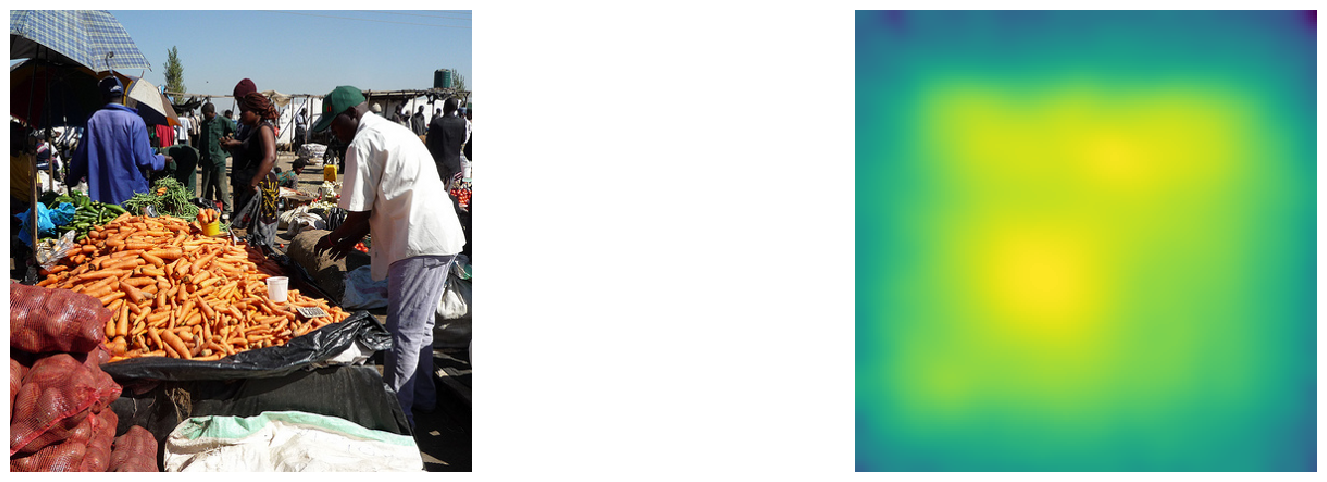

In [52]:
gen_and_plot_saliency(model, image, plot_images=True)

In [53]:
shared1000_list

[2951,
 2991,
 3050,
 3078,
 3147,
 3158,
 3165,
 3172,
 3182,
 3387,
 3435,
 3450,
 3490,
 3627,
 3683,
 3688,
 3730,
 3810,
 3843,
 3848,
 3857,
 3914,
 3952,
 4052,
 4059,
 4130,
 4157,
 4250,
 4326,
 4424,
 4437,
 4613,
 4668,
 4691,
 4769,
 4787,
 4836,
 4870,
 4893,
 4931,
 5035,
 5107,
 5205,
 5286,
 5302,
 5339,
 5428,
 5460,
 5503,
 5543,
 5575,
 5584,
 5603,
 5715,
 5879,
 5891,
 6133,
 6200,
 6223,
 6432,
 6445,
 6490,
 6515,
 6522,
 6525,
 6559,
 6641,
 6714,
 6802,
 7008,
 7040,
 7121,
 7208,
 7337,
 7367,
 7410,
 7419,
 7481,
 7655,
 7660,
 7841,
 7860,
 7945,
 7949,
 7955,
 8007,
 8110,
 8205,
 8226,
 8263,
 8275,
 8319,
 8388,
 8395,
 8416,
 8436,
 8466,
 8510,
 8632,
 8647,
 8808,
 8844,
 8926,
 8934,
 9028,
 9049,
 9148,
 9231,
 9435,
 9463,
 9681,
 9723,
 9805,
 9848,
 9866,
 9918,
 9979,
 10007,
 10047,
 10065,
 10106,
 10108,
 10245,
 10394,
 10472,
 10508,
 10587,
 10601,
 10611,
 10908,
 11160,
 11334,
 11488,
 11522,
 11567,
 11618,
 11636,
 11690,
 11726,
 1179

Generate and plot saliency for the first three images 

Image shape: (425, 425, 3)
Log density prediction shape: torch.Size([1, 1, 425, 425])
Log density prediction shape: torch.Size([1, 1, 425, 425])
Image shape: (425, 425, 3)
Log density prediction shape: torch.Size([1, 1, 425, 425])
Log density prediction shape: torch.Size([1, 1, 425, 425])
Image shape: (425, 425, 3)
Log density prediction shape: torch.Size([1, 1, 425, 425])
Log density prediction shape: torch.Size([1, 1, 425, 425])


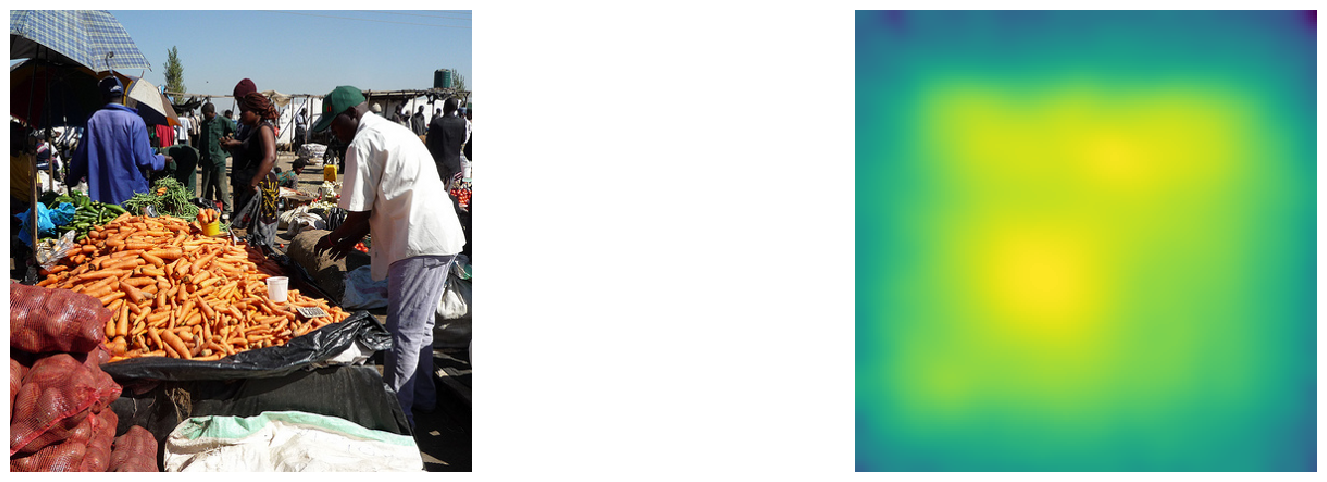

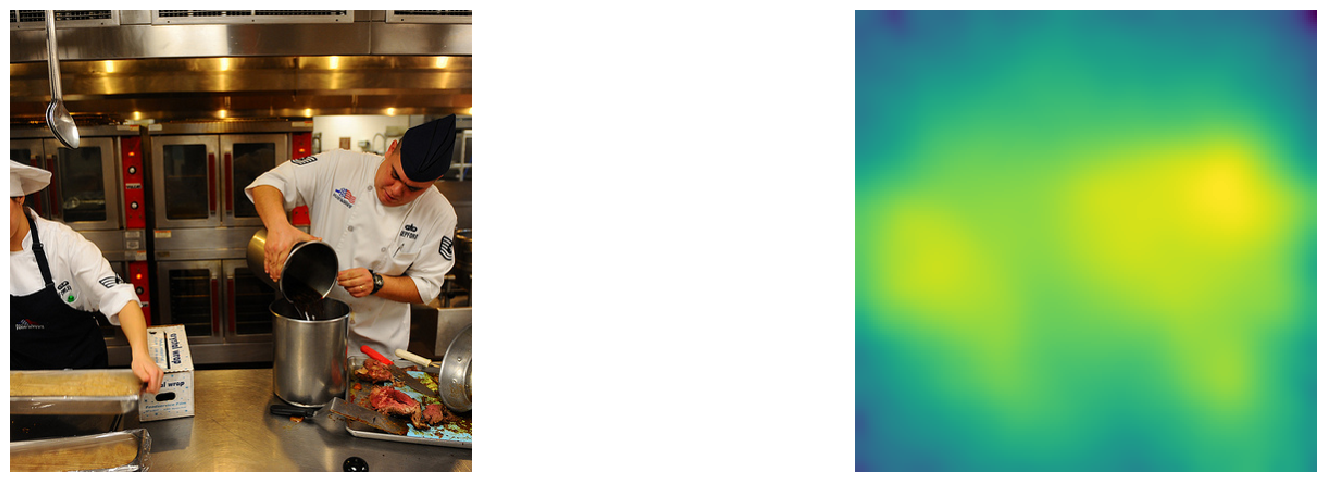

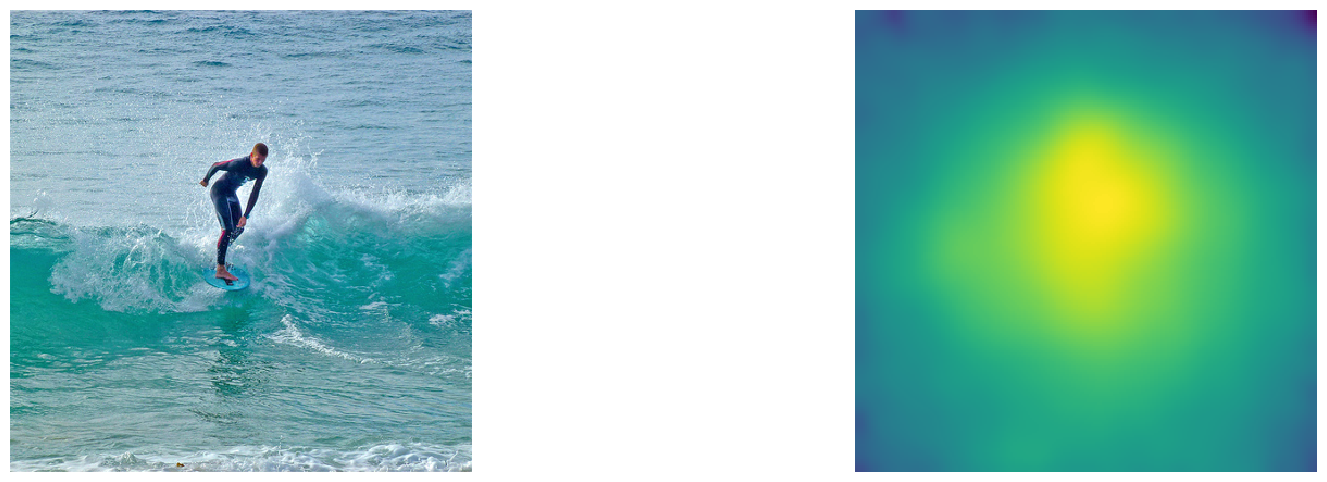

In [ ]:
# Generate and plot saliency map for the first three images 
for i in range(3):
    image = stimuli_numpy_arrays[i]
    log_density_prediction = gen_and_plot_saliency(model, image, channel_loc=2, plot_images=True)
    print(f"Log density prediction shape: {log_density_prediction.shape}")

## Now print applied DeepGazeIIE for all shared1000 images of the NSD Dataset



In [ ]:
""" 
#TODO: Only perfom this if it has not been executed before

# Iterate over all NSD IDs and corresponding images
for nsd_id, image in zip(shared1000_list, stimuli_numpy_arrays):
    print(f"Processing NSD ID: {nsd_id}, Image Shape: {image.shape}")
    
    # Generate and plot the saliency map
    log_density_prediction = gen_and_plot_saliency(model, image)

    # Convert to saliency map (probability density map)
    saliency_map = np.exp(log_density_prediction.detach().numpy())

    # Sanity check: does the saliency map sum to 1
    saliency_map_sum = saliency_map.sum()
    print(f"Saliency map sum: {saliency_map_sum}")

    # Save the saliency map to a file
    saliency_map_file = save_dir / f'saliency_map_DeepGazeIIE_nsd_id_{nsd_id}.npy'
    np.save(saliency_map_file, saliency_map)
    print(f"Saved saliency map for NSD ID {nsd_id} to {saliency_map_file}") """

' \n#TODO: Only perfom this if it \n\n# Iterate over all NSD IDs and corresponding images\nfor nsd_id, image in zip(shared1000_list, stimuli_numpy_arrays):\n    print(f"Processing NSD ID: {nsd_id}, Image Shape: {image.shape}")\n    \n    # Generate and plot the saliency map\n    log_density_prediction = gen_and_plot_saliency(model, image)\n\n    # Convert to saliency map (probability density map)\n    saliency_map = np.exp(log_density_prediction.detach().numpy())\n\n    # Sanity check: does the saliency map sum to 1\n    saliency_map_sum = saliency_map.sum()\n    print(f"Saliency map sum: {saliency_map_sum}")\n\n    # Save the saliency map to a file\n    saliency_map_file = save_dir / f\'saliency_map_DeepGazeIIE_nsd_id_{nsd_id}.npy\'\n    np.save(saliency_map_file, saliency_map)\n    print(f"Saved saliency map for NSD ID {nsd_id} to {saliency_map_file}") '

In [56]:
model 

DeepGazeIIE(
  (models): ModuleList(
    (0): DeepGazeIIIMixture(
      (features): FeatureExtractor(
        (features): RGBShapeNetC(
          (0): Normalizer()
          (1): Sequential(
            (module): ResNet(
              (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
              (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (relu): ReLU(inplace=True)
              (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
              (layer1): Sequential(
                (0): Bottleneck(
                  (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
                  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, aff

In [57]:
""" # Define the directory where .npy files are saved
deepgazeIIE_sal_maps_file_path = save_dir / 'saliency_maps_DeepGazeIIE.h5'  # Path for the consolidated HDF5 file

# Create an HDF5 file
with h5py.File(deepgazeIIE_sal_maps_file_path, 'w') as h5_file:
    # Iterate over all .npy files in the save_dir
    for npy_file in save_dir.glob('*.npy'):
        # Extract the NSD ID from the filename
        nsd_id = npy_file.stem.split('_')[-1]  # Assumes filename format includes 'nsd_id'
        
        # Load the .npy file
        saliency_map = np.load(npy_file)
        
        # Save the saliency map to the HDF5 file
        h5_file.create_dataset(f'nsd_{nsd_id}', data=saliency_map)
        print(f"Added NSD ID {nsd_id} to HDF5 file.")

print(f"All saliency maps consolidated into {deepgazeIIE_sal_maps_file_path}") """

' # Define the directory where .npy files are saved\ndeepgazeIIE_sal_maps_file_path = save_dir / \'saliency_maps_DeepGazeIIE.h5\'  # Path for the consolidated HDF5 file\n\n# Create an HDF5 file\nwith h5py.File(deepgazeIIE_sal_maps_file_path, \'w\') as h5_file:\n    # Iterate over all .npy files in the save_dir\n    for npy_file in save_dir.glob(\'*.npy\'):\n        # Extract the NSD ID from the filename\n        nsd_id = npy_file.stem.split(\'_\')[-1]  # Assumes filename format includes \'nsd_id\'\n        \n        # Load the .npy file\n        saliency_map = np.load(npy_file)\n        \n        # Save the saliency map to the HDF5 file\n        h5_file.create_dataset(f\'nsd_{nsd_id}\', data=saliency_map)\n        print(f"Added NSD ID {nsd_id} to HDF5 file.")\n\nprint(f"All saliency maps consolidated into {deepgazeIIE_sal_maps_file_path}") '

## With applied multiprocessing for faster running. 

In [58]:
""" deepgazeIIE_sal_maps_file_path = save_dir / 'saliency_maps_DeepGazeIIE.h5'  # Path for the consolidated HDF5 file

def process_npy_file(npy_file):
    
    # Load a .npy file and return the NSD ID and saliency map.
    
    try:
        # Extract the NSD ID from the filename
        nsd_id = npy_file.stem.split('_')[-1]  # Assumes filename format includes 'nsd_id'
        
        # Load the .npy file
        saliency_map = np.load(npy_file)
        
        return nsd_id, saliency_map
    except Exception as e:
        print(f"Error processing file {npy_file}: {e}")
        return None

# Main function to consolidate saliency maps into an HDF5 file
def consolidate_saliency_maps():
    # Get a list of all .npy files in the save_dir
    npy_files = list(save_dir.glob('*.npy'))
    
    # Use multiprocessing to process files in parallel
    with Pool(cpu_count()) as pool:
        results = pool.map(process_npy_file, npy_files)
    
    # Create an HDF5 file and save the results
    with h5py.File(deepgazeIIE_sal_maps_file_path, 'w') as h5_file:
        for result in results:
            if result is not None:
                nsd_id, saliency_map = result
                h5_file.create_dataset(f'nsd_{nsd_id}', data=saliency_map)
                print(f"Added NSD ID {nsd_id} to HDF5 file.")
    
    print(f"All saliency maps consolidated into {deepgazeIIE_sal_maps_file_path}")

# Run the consolidation
consolidate_saliency_maps() """

' deepgazeIIE_sal_maps_file_path = save_dir / \'saliency_maps_DeepGazeIIE.h5\'  # Path for the consolidated HDF5 file\n\ndef process_npy_file(npy_file):\n    \n    # Load a .npy file and return the NSD ID and saliency map.\n    \n    try:\n        # Extract the NSD ID from the filename\n        nsd_id = npy_file.stem.split(\'_\')[-1]  # Assumes filename format includes \'nsd_id\'\n        \n        # Load the .npy file\n        saliency_map = np.load(npy_file)\n        \n        return nsd_id, saliency_map\n    except Exception as e:\n        print(f"Error processing file {npy_file}: {e}")\n        return None\n\n# Main function to consolidate saliency maps into an HDF5 file\ndef consolidate_saliency_maps():\n    # Get a list of all .npy files in the save_dir\n    npy_files = list(save_dir.glob(\'*.npy\'))\n    \n    # Use multiprocessing to process files in parallel\n    with Pool(cpu_count()) as pool:\n        results = pool.map(process_npy_file, npy_files)\n    \n    # Create an HDF

## Load images from the h5py file 

In [59]:
# Define the path to the HDF5 file to access the saliency maps
deepgazeIIE_sal_maps_file_path = save_dir / 'saliency_maps_DeepGazeIIE.h5'  # Path for the consolidated HDF5 file

In [60]:
deepgazeIIE_sal_maps_file_path

PosixPath('/gpfs01/bartels/group/lheinemann/saliency-nsd-pub/data/fixation_and_saliency_maps/saliency_maps_DeepGazeIIE.h5')

In [17]:
def get_saliency_deepgaze(nsd_id: Union[List[int], int]) -> Union[np.ndarray, Tuple[np.ndarray, ...]]:
    """
    get_saliency_deepgaze(nsd_id: Union[list, int]) -> np.ndarray or Tuple[np.ndarray, ...]

    Return saliency map(s) for a single image or a series of images given their NSD IDs.

    Parameters
    ----------
    nsd_id: Union[list, int]
        A single NSD ID or a list of NSD IDs for which the saliency maps are to be returned.

    Returns
    -------
    saliency: Union[np.ndarray, Tuple[np.ndarray, ...]]
        A single saliency map if a single NSD ID is provided, or a tuple of saliency maps if
        multiple NSD IDs are provided.
    """
    # Ensure nsd_id is a list for consistent processing
    if isinstance(nsd_id, int):
        nsd_id = [nsd_id]

    # Open the HDF5 file containing the saliency maps
    with h5py.File(deepgazeIIE_sal_maps_file_path, 'r') as h5_file:
        saliency_map_deepgazeIIE = []

        # Iterate over the provided NSD IDs
        for i in nsd_id:
            nsd_id_key = f'nsd_{i}'
            if nsd_id_key in h5_file.keys():
                # Load the saliency map for the current NSD ID
                saliency_map = h5_file[nsd_id_key][:]
                print(f"Loaded saliency map for NSD ID {i}: {saliency_map.shape}")

                # Ensure the saliency map is 2D
                saliency_map = np.squeeze(saliency_map)  # Remove singleton dimensions
                if saliency_map.ndim != 2:
                    raise ValueError(f"Expected a 2D saliency map for NSD ID {i}, but got shape {saliency_map.shape}")

                # Append the saliency map to the list
                saliency_map_deepgazeIIE.append(saliency_map)
            else:
                # Raise an error if the NSD ID is not found in the file
                raise KeyError(f"Dataset '{nsd_id_key}' not found in the HDF5 file.")

    # If there are multiple NSD IDs, return a tuple of saliency maps, else return a single saliency map
    if len(nsd_id) > 1:
        return tuple(saliency_map_deepgazeIIE)
    else:
        return saliency_map_deepgazeIIE[0]

Loaded saliency map for NSD ID 2951: (1, 1, 425, 425)


Text(0.5, 1.0, 'NSD ID: 2951')

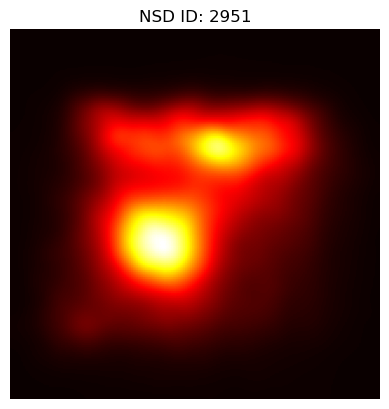

In [74]:
nsd_id = 2951
# Call to get the saliency map for the nsdId 10007
salmap = get_saliency_deepgaze(nsd_id)

# Plot the saliency map for the nsdId 10007
plt.imshow(salmap, cmap='hot')
plt.axis('off')
# 
# Add a title to the plot
plt.title(f'NSD ID: {nsd_id}')


In [67]:
# Load the shared1000_list and give back an index list of the ids starting with 1

shared1000_list
# Create a list of indices starting from 1 
indices = list(range(1, len(shared1000_list) + 1))
# Print the list of indices
print(indices)

# print borth lists in a dataframe
df = pd.DataFrame({'Index': indices, 'NSD ID': shared1000_list})
# Print the DataFrame  
print(df)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 22

In [70]:
stimuli_numpy_arrays

[array([[[113, 134, 163],
         [100, 122, 145],
         [114, 128, 154],
         ...,
         [131, 170, 203],
         [134, 168, 203],
         [133, 167, 202]],
 
        [[118, 148, 159],
         [134, 163, 161],
         [136, 156, 163],
         ...,
         [126, 169, 209],
         [129, 169, 205],
         [126, 169, 204]],
 
        [[132, 156, 180],
         [131, 152, 173],
         [156, 174, 174],
         ...,
         [137, 168, 196],
         [142, 168, 197],
         [140, 169, 199]],
 
        ...,
 
        [[161,  51,  50],
         [ 85,   6,  10],
         [157,  55,  40],
         ...,
         [ 12,  12,  12],
         [ 10,  10,  10],
         [  9,   9,   9]],
 
        [[165,  55,  53],
         [ 82,   6,   6],
         [138,  47,  27],
         ...,
         [ 12,  12,  12],
         [ 10,  10,  10],
         [ 11,  11,  11]],
 
        [[158,  57,  49],
         [107,  21,  20],
         [176,  67,  47],
         ...,
         [ 13,  13,  13],
  

# Visualization

For the visualization plot an overlay of generated saliency predictions and corresponding nsd stimulus id. 

Loaded saliency map for NSD ID 9028: (1, 1, 425, 425)


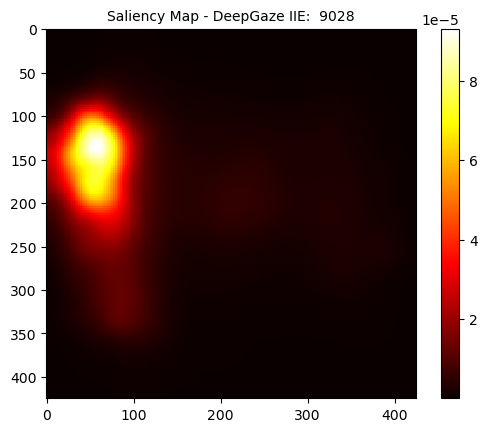

Saved overlay to /gpfs01/bartels/group/lheinemann/saliency-nsd-pub/data/fixation_and_saliency_maps/deepgazeIIE_saliency_map_overlay_all_fixations_nsd_stimulus_id_9028.png


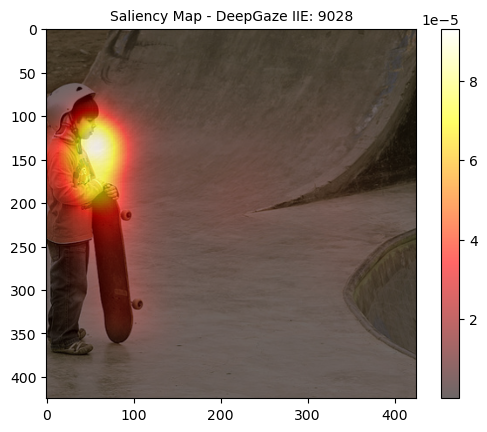

In [80]:
###########################################################################
nsd_id = 9028
# Call to get the saliency map for the nsdId 10007
salmap = get_saliency_deepgaze(nsd_id)
# Display the saliency map
plt.imshow(salmap, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title(f'Saliency Map - DeepGaze IIE:  {nsd_id}', fontsize= 10)
# Save the plot to a png file
save_path = save_dir / f'deepgazeIIE_saliency_map_all_fixations_nsd_stimulus_id_{nsd_id}'
plt.savefig(f'{save_path}.png')

plt.show()

################### Overlay the saliency map on the image ###################
# Get the index for the nsd id from the dataframe


# Get the index of the nsd id stored in the dataframe df

# Look for the nsd_id in the dataframe df and get its index
df_index_list = df[df['NSD ID'] == nsd_id].index.tolist()

if df_index_list:
    df_index = df_index_list[0]  # Get the first index
    image = stimuli_numpy_arrays[df_index]
    plt.imshow(image)
else:
    print(f"NSD ID {nsd_id} not found in the dataframe.")
# Overlay the saliency map with a trasparency of alpha = 0.7, TODO: Change to 0.5 if the code works s
plt.imshow(salmap, cmap='hot', alpha=0.6)

# Add a colorbar and title
plt.colorbar()
plt.title(f'Saliency Map - DeepGaze IIE: {nsd_id}', fontsize=10)

# Save the plot to a png file
save_path = save_dir / f'deepgazeIIE_saliency_map_overlay_all_fixations_nsd_stimulus_id_{nsd_id}'
plt.savefig(f'{save_path}.png')
# if saved send a confirmation message
print(f'Saved overlay to {save_path}.png')

# Shows the image in the console 
plt.show()

### Execute the saliency maps for all shared1000 NSD IDs. 

Loop through all NSD IDs in your DataFrame.
Load the saliency map and corresponding image.
Save both the saliency map and the overlay as PNG files.
Print a confirmation for each saved overlay.
Handle errors gracefully and continue with the next NSD ID.

In [77]:
for nsd_id in df['NSD ID']:
    try:
        # Get the saliency map for the current nsd_id
        salmap = get_saliency_deepgaze(nsd_id)
        
        # Save and show the saliency map
        plt.figure()
        plt.imshow(salmap, cmap='hot', interpolation='nearest')
        plt.colorbar()
        plt.title(f'Saliency Map - DeepGaze IIE: {nsd_id}', fontsize=10)
        save_path = save_dir / f'deepgazeIIE_saliency_map_all_fixations_nsd_stimulus_id_{nsd_id}'
        plt.savefig(f'{save_path}.png')
        plt.close()

        # Overlay the saliency map on the corresponding image
        df_index_list = df[df['NSD ID'] == nsd_id].index.tolist()
        if df_index_list:
            df_index = df_index_list[0]
            image = stimuli_numpy_arrays[df_index]
            plt.figure()
            plt.imshow(image)
        else:
            print(f"NSD ID {nsd_id} not found in the dataframe.")
            continue

        plt.imshow(salmap, cmap='hot', alpha=0.6)
        plt.colorbar()
        plt.title(f'Saliency Map - DeepGaze IIE: {nsd_id}', fontsize=10)
        save_path = save_dir / f'deepgazeIIE_saliency_map_overlay_all_fixations_nsd_stimulus_id_{nsd_id}'
        plt.savefig(f'{save_path}.png')
        print(f'Saved overlay to {save_path}.png')
        plt.close()
    except Exception as e:
        print(f"Error processing NSD ID {nsd_id}: {e}")

Loaded saliency map for NSD ID 2951: (1, 1, 425, 425)
Saved overlay to /gpfs01/bartels/group/lheinemann/saliency-nsd-pub/data/fixation_and_saliency_maps/deepgazeIIE_saliency_map_overlay_all_fixations_nsd_stimulus_id_2951.png
Loaded saliency map for NSD ID 2991: (1, 1, 425, 425)
Saved overlay to /gpfs01/bartels/group/lheinemann/saliency-nsd-pub/data/fixation_and_saliency_maps/deepgazeIIE_saliency_map_overlay_all_fixations_nsd_stimulus_id_2991.png
Loaded saliency map for NSD ID 3050: (1, 1, 425, 425)
Saved overlay to /gpfs01/bartels/group/lheinemann/saliency-nsd-pub/data/fixation_and_saliency_maps/deepgazeIIE_saliency_map_overlay_all_fixations_nsd_stimulus_id_3050.png
Loaded saliency map for NSD ID 3078: (1, 1, 425, 425)
Saved overlay to /gpfs01/bartels/group/lheinemann/saliency-nsd-pub/data/fixation_and_saliency_maps/deepgazeIIE_saliency_map_overlay_all_fixations_nsd_stimulus_id_3078.png
Loaded saliency map for NSD ID 3147: (1, 1, 425, 425)
Saved overlay to /gpfs01/bartels/group/lheinem